               Model    Val MAE   Val RMSE   Test MAE  Test RMSE
0       Naive lag-24  28.581881  57.589848  40.466904  69.042609
1  Linear Regression   9.638602  21.357472  10.303715  19.200723
2      Random Forest   9.020073  24.203931   9.017259  18.379650


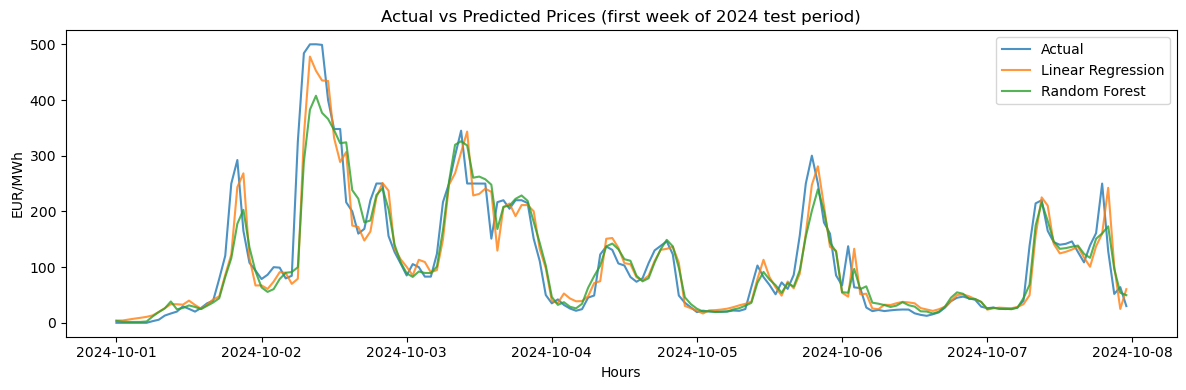

In [10]:
import pandas as pd
import numpy as np
from glob import glob
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

files = sorted(glob("data/AuctionPrice_*_DayAhead_FI_EUR_None.csv"))
df = pd.concat([pd.read_csv(f, sep=";") for f in files], ignore_index=True)
df["DateTime"] = pd.to_datetime(df["Delivery Start (EET)"],
                                format="%d.%m.%Y %H:%M:%S",
                                errors="coerce")
                                
df = df.set_index("DateTime").sort_index()
df = df[["FI Price (EUR)"]].rename(columns={"FI Price (EUR)":"Price_EUR_MWh"})
df = df[df["Price_EUR_MWh"] < 1000]
df["hour"] = df.index.hour
df["weekday"] = df.index.weekday
df["month"] = df.index.month
df["sin_hour"] = np.sin(2*np.pi*df["hour"]/24)
df["cos_hour"] = np.cos(2*np.pi*df["hour"]/24)
df["sin_wday"] = np.sin(2*np.pi*df["weekday"]/7)
df["cos_wday"] = np.cos(2*np.pi*df["weekday"]/7)
df["sin_month"] = np.sin(2*np.pi*df["month"]/12)
df["cos_month"] = np.cos(2*np.pi*df["month"]/12)
df["lag_1"] = df["Price_EUR_MWh"].shift(1)
df["lag_24"] = df["Price_EUR_MWh"].shift(24)
df["lag_168"] = df["Price_EUR_MWh"].shift(168)
df["mean_3h"] = df["Price_EUR_MWh"].rolling(3).mean().shift(1)
df["mean_24h"] = df["Price_EUR_MWh"].rolling(24).mean().shift(1)
df = df.dropna()
train = df.loc["2020-01-01":"2023-12-31"]
val   = df.loc["2024-01-01":"2024-09-30"]
test  = df.loc["2024-10-01":"2024-12-31"]
features = ["hour","weekday","month",
            "sin_hour","cos_hour","sin_wday","cos_wday",
            "sin_month","cos_month",
            "lag_1","lag_24","lag_168","mean_3h","mean_24h"]
def evaluate(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return mae, rmse
lr = LinearRegression().fit(train[features], train["Price_EUR_MWh"])
rf = RandomForestRegressor(
    n_estimators=120,
    max_depth=16,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
).fit(train[features], train["Price_EUR_MWh"])
val_naive = val["lag_24"]
test_naive = test["lag_24"]
results = pd.DataFrame([
    ["Naive lag-24", *evaluate(val["Price_EUR_MWh"], val_naive),
     *evaluate(test["Price_EUR_MWh"], test_naive)],
    ["Linear Regression", *evaluate(val["Price_EUR_MWh"],
     lr.predict(val[features])),
     *evaluate(test["Price_EUR_MWh"], lr.predict(test[features]))],
    ["Random Forest", *evaluate(val["Price_EUR_MWh"],
     rf.predict(val[features])),
     *evaluate(test["Price_EUR_MWh"], rf.predict(test[features]))]
], columns=["Model","Val MAE","Val RMSE","Test MAE","Test RMSE"])
print(results)
sample = test.iloc[:24*7]
plt.figure(figsize=(12,4))
plt.plot(sample.index, sample["Price_EUR_MWh"], label="Actual", alpha=0.8)
plt.plot(sample.index, lr.predict(sample[features]),
         label="Linear Regression", alpha=0.8)
plt.plot(sample.index, rf.predict(sample[features]),
         label="Random Forest", alpha=0.8)
plt.legend()
plt.title("Actual vs Predicted Prices (first week of 2024 test period)")
plt.ylabel("EUR/MWh")
plt.xlabel("Hours")
plt.tight_layout()
plt.savefig("test_week_plot.png", dpi=300)
plt.show()